In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve

# Leitura dos dados

In [3]:
df = pd.read_csv('titanic.csv')

In [4]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
df.shape

(891, 12)

# Organizando dados

In [6]:
#Group age into 4 buckets
def age_config(allset):
    allset['AgeBand']=''
    allset.loc[allset['Age']<=1,'AgeBand']='Infant'
    allset.loc[(allset['Age']>1) & (allset['Age']<=10),'AgeBand']='YoungChild'
    allset.loc[(allset['Age']>10) & (allset['Age']<=60),'AgeBand']='Adults'
    allset.loc[allset['Age']>60,'AgeBand']='Seniors'
    
    return allset
df = age_config(df)

In [7]:
def fare_config(dataset):
    dataset['Fare_group']=''
    dataset['Fare'] = dataset['Fare'].astype(float)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare_group'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare_group'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare_group']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare_group'] = 3


    return dataset
df = fare_config(df)

In [8]:
df = pd.concat([df.drop(['Sex'], axis=1), pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
df = pd.concat([df.drop(['Pclass'], axis=1), pd.get_dummies(df['Pclass'], prefix='Pclass')], axis=1)
df = pd.concat([df.drop(['AgeBand'], axis=1), pd.get_dummies(df['AgeBand'], prefix='AgeBand')], axis=1)
df = pd.concat([df.drop(['Fare_group'], axis=1), pd.get_dummies(df['Fare_group'], prefix='Fare_group')], axis=1)

In [9]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,AgeBand_,AgeBand_Adults,AgeBand_Infant,AgeBand_Seniors,AgeBand_YoungChild,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,1,0,0,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,0,1,0,0,0,0,0,0,1
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1,0,1,0,0,0,0,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,0,0,0,1,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1,0,1,0,0,0,0,1,0,0


# Separando em dados de treinamento e teste

In [48]:
X = df.drop(['Survived', 'PassengerId', 'Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin','Embarked', 'Fare'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [49]:
X_train.head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,AgeBand_,AgeBand_Adults,AgeBand_Infant,AgeBand_Seniors,AgeBand_YoungChild,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3
570,0,1,0,1,0,0,0,0,1,0,0,1,0,0
787,0,1,0,0,1,0,0,0,0,1,0,0,1,0
74,0,1,0,0,1,0,1,0,0,0,0,0,0,1
113,1,0,0,0,1,0,1,0,0,0,0,1,0,0
635,1,0,0,1,0,0,1,0,0,0,0,1,0,0


# Kmeans

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
data=X
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [52]:
Sum_of_squared_distances = []
K = range(1,len(X))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

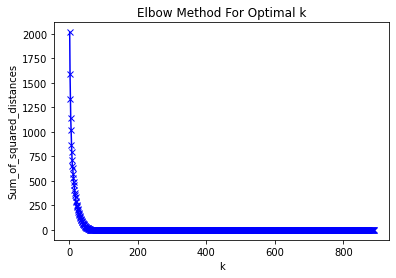

In [53]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [94]:
kmeans = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(data_transformed)

In [95]:
from collections import Counter
Counter(y_kmeans)

Counter({1: 499, 0: 392})

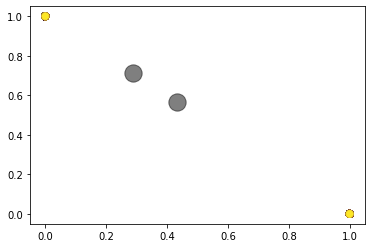

In [97]:
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.5)

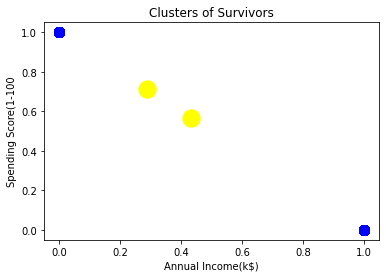

In [98]:
#6 Visualising the clusters
plt.scatter(data_transformed[y_kmeans==0, 0], data_transformed[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(data_transformed[y_kmeans==1, 0], data_transformed[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
# plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
# plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=100, c='cyan', label ='Cluster 4')
# plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=100, c='magenta', label ='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Survivors')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()